In [140]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import camb
import healpy as hp
from classy import Class
from multiprocess import Pool,get_context
import corner
import clik

In [141]:
l = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', usecols = 0)
Dl = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', usecols = 1)
Dl_minus = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', usecols = 2)
Dl_plus = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', usecols = 3)

l = l[:2499]
Dl = Dl[:2499]
Dl_minus = Dl_minus[:2499]
Dl_plus = Dl_plus[:2499]

print(l)
l_theory = np.arange(2, 2501)

print(l_theory)
np.size(l)

[2.000e+00 3.000e+00 4.000e+00 ... 2.498e+03 2.499e+03 2.500e+03]
[   2    3    4 ... 2498 2499 2500]


2499

In [142]:
sigma = (Dl_minus+Dl_plus/2)
np.size(sigma)

2499

In [179]:
# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    'output': 'tCl lCl',
    'l_max_scalars': 2500,
    'lensing': 'yes',
    'A_s': 2.5e-9,
    'n_s': 0.9624, 
    'h': 0.6711,
    'omega_b': 0.022068,
    'omega_cdm': 0.12029}

# Create an instance of the CLASS wrapper
cosmo = Class()

# Set the parameters to the cosmological code
cosmo.set(params)

# Run the whole code. Depending on your output, it will call the
# CLASS modules more or less fast. For instance, without any
# output asked, CLASS will only compute background quantities,
# thus running almost instantaneously.
# This is equivalent to the beginning of the `main` routine of CLASS,
# with all the struct_init() methods called.
cosmo.compute()

# Access the lensed cl until l=2000
cls = cosmo.lensed_cl(2500)
l_theory = np.arange(2, 2501)

Dl_theory = cls['tt'][2:] * l_theory * (l_theory + 1) * 1e12

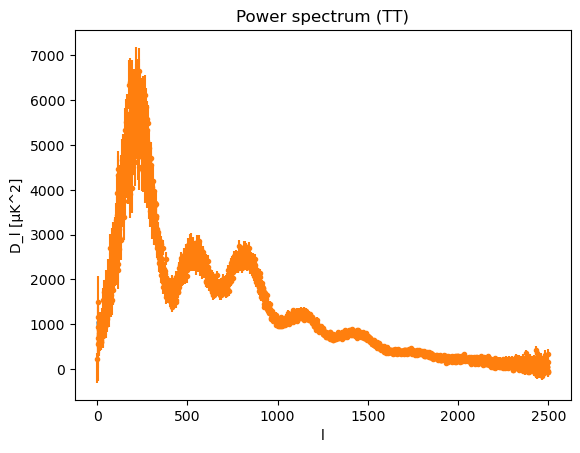

In [180]:
plt.plot(l_theory,Dl_theory)
plt.errorbar(l, Dl, yerr=[Dl_plus,Dl_minus], xerr=None, fmt='.')
plt.ylabel('D_l [μK^2]')
plt.xlabel('l')
plt.title('Power spectrum (TT)')
plt.savefig('Power_spectrum.pdf')


In [181]:
def likelihood(theta, l, Dl, Dl_minus, Dl_plus):
    # Correct the order of parameters
    ln_A_s, n_s, H0, Omega_b, Omega_cdm = theta

    A_s = np.exp(ln_A_s)
    params = {
        'output': 'tCl lCl',
        'l_max_scalars': 2500,
        'lensing': 'yes',
        'A_s': A_s,
        'n_s': n_s, 
        'h': H0/100,  # H0 in terms of H0/100
        'omega_b': Omega_b,
        'omega_cdm': Omega_cdm
    }

    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()

    l_theory = np.arange(2, 2501)
    
    cls = cosmo.lensed_cl()
    Dl_theory = cls['tt'][2:] * l_theory * (l_theory + 1) * 1e12

    chi2 = np.sum(((Dl - Dl_theory)**2) / (Dl_minus**2 + Dl_plus**2))
    return -0.5 * chi2

In [182]:
def lnprior(theta):
    ln_A_s, n_s, H0, Omega_b, Omega_cdm = theta
    if (-30<ln_A_s<0 and 0.8<n_s< 1.2 and 50 < H0 < 70 and
        0 < Omega_b < 0.03 and 0 < Omega_cdm < 0.5):
        return 0.0
    return -np.inf

In [183]:
def lnprob(theta, l, Dl, Dl_minus, Dl_plus):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + likelihood(theta, l, Dl, Dl_minus, Dl_plus)

In [184]:
A_s_0 = np.log(2.3e-9)
n_s_0 = 0.9624
h_0 = 0.6711
omega_b_0 = 0.022068
omega_cdm_0 = 0.12029

In [185]:
theta = [A_s_0, n_s_0, h_0, omega_b_0, omega_cdm_0]
nll = lambda *args: -likelihood(*args)
Minimize = op.minimize(nll, theta,args=(l, Dl, Dl_minus, Dl_plus),
                       bounds=((-30, 0.1**2), (0.8,1.2), (60, 80), (0.01, 0.03), (0.01, 0.5)))
print("Minimized parameters:", Minimize['x'])

Minimized parameters: [-1.98903567e+01  9.62400000e-01  6.00000000e+01  2.20680000e-02
  1.20290000e-01]


In [ ]:
ndim = 5
nwalker = 100
nsteps = 1000
burn = 100

pos = [Minimize["x"] + 1e-4 * np.random.randn(ndim) for i in range(nwalker)]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalker,ndim,lnprob,args = (l,Dl,Dl_minus, Dl_plus), pool=pool)
    sampler.run_mcmc(pos,nsteps, progress=True)
    samples1 = sampler.chain[:,burn:,:].reshape((-1,ndim))

  2%|▋                                 | 21/1000 [28:17<24:02:12, 88.39s/it]

In [ ]:
fig = plt.figure()
corner.corner(samples1,labels=["exp(A_s)","n_s","H","omega_b","omega_cdm"],color = "blue",plot_density=True, smooth=True,storechain=True, plot_datapoints=False, 
                        fill_contours=True,show_titles=True,title_fmt = '.3f',bins=100)
plt.savefig("Plank_2018.png",dpi=400)
plt.show()

In [95]:
test_theta = [2.29703807e-09, 0.962941293, 60, 0.022040507, 0.121155044]
print("Likelihood for minimized parameters:", likelihood(test_theta, l, Dl, sigma))


Likelihood for minimized parameters: -1219.896078512976


In [78]:
test_theta = [2.1e-9, 0.96, 67.4, 0.022, 0.12]  # Example input
print(likelihood(test_theta, l, Dl, Dl_minus, Dl_plus))

-1431.538193800896


In [94]:
print("lnprior for minimized parameters:", lnprior([2.29703807e-09, 0.962941293, 60, 0.022040507, 0.121155044]))

lnprior for minimized parameters: 0.0


In [ ]:
clik_file = '/Users/robertrugg/Downloads/baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22_TT.clik'
likelihood = clik.clik(clik_file)

def likelihood(theta):
    A_s, n_s, H0, Omega_b, Omega_cdm = theta
    params = {
        'A_s': A_s,
        'n_s': n_s,
        'h': H0 / 100,
        'omega_b': Omega_b,
        'omega_cdm': Omega_cdm
    }

    param_vector = [
        params['omega_b'], 
        params['omega_cdm'], 
        params['h'], 
        params['n_s'], 
        params['A_s']
    ]

    try:
        loglike = likelihood()(l, Dl, Dl_model, Dl_minus, Dl_plus)
    except Exception as e:
        loglike = -np.inf
        print(f"Error in likelihood calculation: {e}")
    
    return loglike

In [96]:
test_theta = [2.29703807e-09, 0.962941293, 60, 0.022040507, 0.121155044]
print("lnprob for minimized parameters:", lnprob(test_theta, l, Dl, sigma))

lnprob for minimized parameters: -1219.896078512976


In [2]:
import numpy as np
print(np.__version__)

2.2.1


In [39]:
print(type(clik))

<class 'module'>


In [40]:
print(dir(likelihood))  # This will show all the available methods of the 'likelihood' object


['__annotations__', '__builtins__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__getstate__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__type_params__']


In [97]:
test_theta = [2.29703807e-09, 0.962941293, 60, 0.022040507, 0.121155044]
print("lnprob for minimized parameters:", lnprob(test_theta, l, Dl, sigma))


lnprob for minimized parameters: -1219.896078512976


In [98]:
for idx, p in enumerate(pos):
    print(f"Walker {idx} initial position: {p}, lnprior: {lnprior(p)}")

Walker 0 initial position: [-4.53897850e-05  9.62816936e-01  6.00000981e+01  2.20390477e-02
  1.21058378e-01], lnprior: -inf
Walker 1 initial position: [6.48327392e-05 9.62743027e-01 6.00000367e+01 2.21255083e-02
 1.21067698e-01], lnprior: -inf
Walker 2 initial position: [-1.43292709e-04  9.62923677e-01  5.99998692e+01  2.20631320e-02
  1.21052613e-01], lnprior: -inf
Walker 3 initial position: [1.36950053e-04 9.62926599e-01 6.00000453e+01 2.19335018e-02
 1.21342361e-01], lnprior: -inf
Walker 4 initial position: [8.65388754e-05 9.62908801e-01 5.99999119e+01 2.21713281e-02
 1.21145276e-01], lnprior: -inf
Walker 5 initial position: [-1.90216154e-04  9.62831900e-01  5.99996988e+01  2.18719727e-02
  1.20985276e-01], lnprior: -inf
Walker 6 initial position: [-2.61106903e-04  9.62916004e-01  6.00000295e+01  2.20132729e-02
  1.21014799e-01], lnprior: -inf
Walker 7 initial position: [-1.35092262e-05  9.63055931e-01  5.99999091e+01  2.21907902e-02
  1.21119858e-01], lnprior: -inf
Walker 8 initia

In [100]:
# Ensure walkers start in a reasonable range, adding larger perturbations to test
pos = [
    np.array(test_theta) + np.random.randn(ndim) * 1e-2  # Increase step size
    for i in range(nwalker)
]